In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


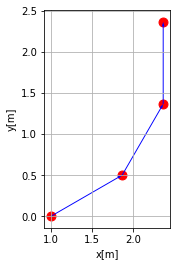

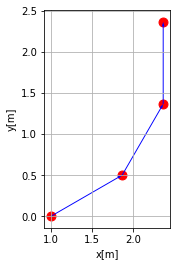

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 5000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.5 # [m/s]
DATA_MAX_ROTATE_VEL = xp.pi * 0.5# [rad/s]
DATA_M_PER_STEP = 0.03 # [m/step]
DATA_RAD_PER_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :',DATA_RAD_PER_STEP)

X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    rand_trans_x = xp.random.rand() * DATA_M_PER_STEP
    d_trans = data.translate_path(d,rand_trans_x,0.0)
    rand_rotate = xp.random.rand()*(xp.pi)-xp.pi/2
    d_rotate = data.rotate_path(d_trans,rand_rotate)
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 5000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.5
DATA_MAX_ROTATE_VEL: 1.5707963267948966
DATA_M_PER_STEP    : 0.03
DATA_RAD_PER_STEP  : 0.15707963267948966
5000
(10, 3)


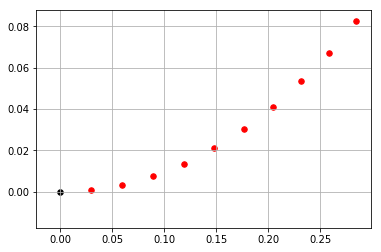

 -- x_train -- 
[[ 2.99840187e-02  8.47874092e-04 -1.51425633e+00]
 [ 5.98722109e-02  3.38878663e-03 -1.45771633e+00]
 [ 8.95690562e-02  7.61461706e-03 -1.40117633e+00]
 [ 1.18979646e-01  1.35118600e-02 -1.34463633e+00]
 [ 1.48009986e-01  2.10616682e-02 -1.28809633e+00]
 [ 1.76567299e-01  3.02399133e-02 -1.23155633e+00]
 [ 2.04560316e-01  4.10172622e-02 -1.17501633e+00]
 [ 2.31899575e-01  5.33592713e-02 -1.11847633e+00]
 [ 2.58497701e-01  6.72264967e-02 -1.06193633e+00]
 [ 2.84269690e-01  8.25746198e-02 -1.00539633e+00]]


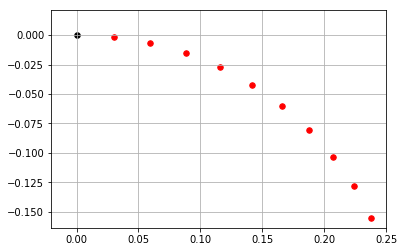

 -- x_train -- 
[[ 2.99332163e-02 -1.73221935e-03 -1.68640633e+00]
 [ 5.94668004e-02 -6.90575091e-03 -1.80201633e+00]
 [ 8.82064557e-02 -1.54515239e-02 -1.91762633e+00]
 [ 1.15768485e-01 -2.72554456e-02 -2.03323633e+00]
 [ 1.41784913e-01 -4.21599242e-02 -2.14884633e+00]
 [ 1.65908401e-01 -5.99659731e-02 -2.26445633e+00]
 [ 1.87816879e-01 -8.04358674e-02 -2.38006633e+00]
 [ 2.07217854e-01 -1.03296318e-01 -2.49567633e+00]
 [ 2.23852306e-01 -1.28242120e-01 -2.61128633e+00]
 [ 2.37498153e-01 -1.54940226e-01 -2.72689633e+00]]


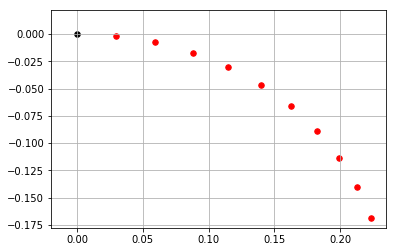

 -- x_train -- 
[[ 2.99166064e-02 -1.93530564e-03 -1.69999633e+00]
 [ 5.93345200e-02 -7.70896211e-03 -1.82919633e+00]
 [ 8.77633608e-02 -1.72247258e-02 -1.95839633e+00]
 [ 1.14729236e-01 -3.03239744e-02 -2.08759633e+00]
 [ 1.39782640e-01 -4.67883508e-02 -2.21679633e+00]
 [ 1.62505947e-01 -6.63434033e-02 -2.34599633e+00]
 [ 1.82520372e-01 -8.86631601e-02 -2.47519633e+00]
 [ 1.99492286e-01 -1.13375564e-01 -2.60439633e+00]
 [ 2.13138777e-01 -1.40068672e-01 -2.73359633e+00]
 [ 2.23232365e-01 -1.68297527e-01 -2.86279633e+00]]


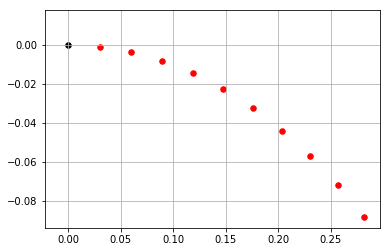

 -- x_train -- 
[[ 2.99815567e-02 -9.10819921e-04 -1.63153633e+00]
 [ 5.98525349e-02 -3.63992038e-03 -1.69227633e+00]
 [ 8.95027643e-02 -8.17723589e-03 -1.75301633e+00]
 [ 1.18822888e-01 -1.45060318e-02 -1.81375633e+00]
 [ 1.47704768e-01 -2.26029663e-02 -1.87449633e+00]
 [ 1.76041881e-01 -3.24381760e-02 -1.93523633e+00]
 [ 2.03729715e-01 -4.39753867e-02 -1.99597633e+00]
 [ 2.30666149e-01 -5.71720466e-02 -2.05671633e+00]
 [ 2.56751837e-01 -7.19794836e-02 -2.11745633e+00]
 [ 2.81890570e-01 -8.83430847e-02 -2.17819633e+00]]


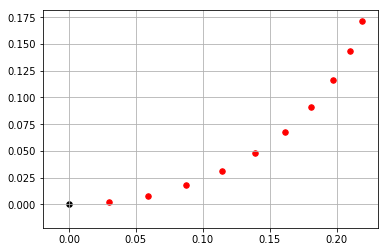

 -- x_train -- 
[[ 0.02991162  0.00199221 -1.43778633]
 [ 0.05929483  0.00793365 -1.30477633]
 [ 0.08763057  0.01771935 -1.17176633]
 [ 0.11441826  0.03117646 -1.03875633]
 [ 0.13918468  0.04806723 -0.90574633]
 [ 0.16149232  0.06809329 -0.77273633]
 [ 0.18094711  0.09090086 -0.63972633]
 [ 0.19720536  0.11608703 -0.50671633]
 [ 0.20997985  0.14320688 -0.37370633]
 [ 0.21904493  0.17178131 -0.24069633]]


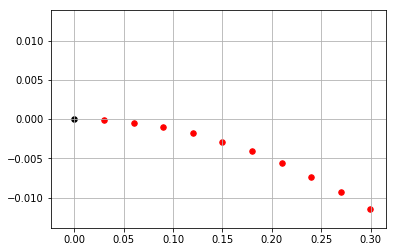

 -- x_train -- 
[[ 2.99997089e-02 -1.14449445e-04 -1.57842633e+00]
 [ 5.99976714e-02 -4.57791116e-04 -1.58605633e+00]
 [ 8.99921409e-02 -1.03000503e-03 -1.59368633e+00]
 [ 1.19981371e-01 -1.83105786e-03 -1.60131633e+00]
 [ 1.49963617e-01 -2.86090299e-03 -1.60894633e+00]
 [ 1.79937132e-01 -4.11948045e-03 -1.61657633e+00]
 [ 2.09900172e-01 -5.60671699e-03 -1.62420633e+00]
 [ 2.39850992e-01 -7.32252600e-03 -1.63183633e+00]
 [ 2.69787849e-01 -9.26680762e-03 -1.63946633e+00]
 [ 2.99709000e-01 -1.14394486e-02 -1.64709633e+00]]


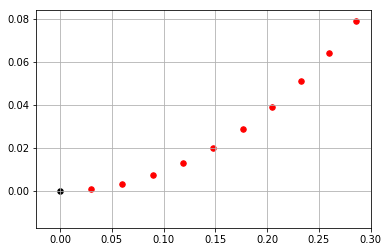

 -- x_train -- 
[[ 2.99854653e-02  8.08604062e-04 -1.51687633e+00]
 [ 5.98837729e-02  3.23206591e-03 -1.46295633e+00]
 [ 8.96080187e-02  7.26334136e-03 -1.40903633e+00]
 [ 1.19071804e-01  1.28907129e-02 -1.35511633e+00]
 [ 1.48189488e-01  2.00978235e-02 -1.30119633e+00]
 [ 1.76876436e-01  2.88637248e-02 -1.24727633e+00]
 [ 2.05049263e-01  3.91629370e-02 -1.19335633e+00]
 [ 2.32626081e-01  5.09655240e-02 -1.13943633e+00]
 [ 2.59526734e-01  6.42371795e-02 -1.08551633e+00]
 [ 2.85673031e-01  7.89393273e-02 -1.03159633e+00]]


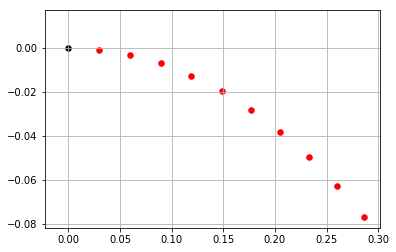

 -- x_train -- 
[[ 2.99861786e-02 -7.88518310e-04 -1.62337633e+00]
 [ 5.98894749e-02 -3.15189376e-03 -1.67595633e+00]
 [ 8.96272354e-02 -7.08359393e-03 -1.72853633e+00]
 [ 1.19117265e-01 -1.25727515e-02 -1.78111633e+00]
 [ 1.48278051e-01 -1.96041944e-02 -1.83369633e+00]
 [ 1.77028995e-01 -2.81584876e-02 -1.88627633e+00]
 [ 2.05290626e-01 -3.82119867e-02 -1.93885633e+00]
 [ 2.32984831e-01 -4.97369038e-02 -1.99143633e+00]
 [ 2.60035060e-01 -6.27013837e-02 -2.04401633e+00]
 [ 2.86366548e-01 -7.70695924e-02 -2.09659633e+00]]


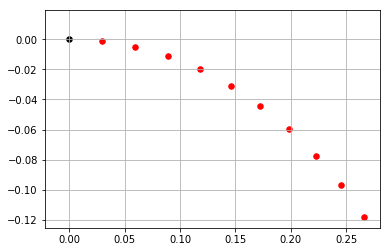

 -- x_train -- 
[[ 2.99650758e-02 -1.25312009e-03 -1.65438633e+00]
 [ 5.97208988e-02 -5.00372953e-03 -1.73797633e+00]
 [ 8.90596776e-02 -1.12256370e-02 -1.82156633e+00]
 [ 1.17776533e-01 -1.98753935e-02 -1.90515633e+00]
 [ 1.45670929e-01 -3.08925960e-02 -1.98874633e+00]
 [ 1.72548073e-01 -4.42003088e-02 -2.07233633e+00]
 [ 1.98220275e-01 -5.97056013e-02 -2.15592633e+00]
 [ 2.22508262e-01 -7.73001966e-02 -2.23951633e+00]
 [ 2.45242424e-01 -9.68612277e-02 -2.32310633e+00]
 [ 2.66264005e-01 -1.18252096e-01 -2.40669633e+00]]


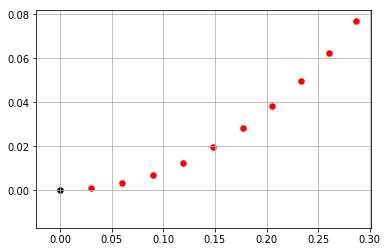

 -- x_train -- 
[[ 2.99862259e-02  7.87169241e-04 -1.51830633e+00]
 [ 5.98898527e-02  3.14650865e-03 -1.46581633e+00]
 [ 8.96285089e-02  7.07151928e-03 -1.41332633e+00]
 [ 1.19120277e-01  1.25513894e-02 -1.36083633e+00]
 [ 1.48283921e-01  1.95710244e-02 -1.30834633e+00]
 [ 1.77039106e-01  2.81110881e-02 -1.25585633e+00]
 [ 2.05306626e-01  3.81480564e-02 -1.20336633e+00]
 [ 2.33008614e-01  4.96542818e-02 -1.15087633e+00]
 [ 2.60068764e-01  6.25980696e-02 -1.09838633e+00]
 [ 2.86412537e-01  7.69437653e-02 -1.04589633e+00]]


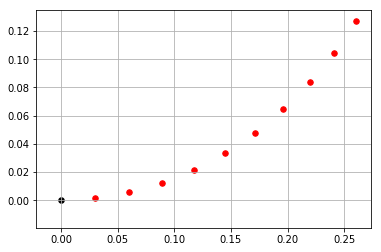

 -- x_train -- 
[[ 2.99585940e-02  1.36435768e-03 -1.47977633e+00]
 [ 5.96691630e-02  5.44613529e-03 -1.38875633e+00]
 [ 8.88857357e-02  1.22115401e-02 -1.29773633e+00]
 [ 1.17366430e-01  2.16045619e-02 -1.20671633e+00]
 [ 1.44875457e-01  3.35474366e-02 -1.11569633e+00]
 [ 1.71185072e-01  4.79412899e-02 -1.02467633e+00]
 [ 1.96077458e-01  6.46669565e-02 -9.33656327e-01]
 [ 2.19346535e-01  8.35859656e-02 -8.42636327e-01]
 [ 2.40799658e-01  1.04541688e-01 -7.51616327e-01]
 [ 2.60259220e-01  1.27360634e-01 -6.60596327e-01]]


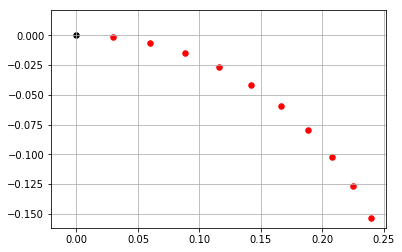

 -- x_train -- 
[[ 2.99352215e-02 -1.70605568e-03 -1.68465633e+00]
 [ 5.94827789e-02 -6.80212914e-03 -1.79851633e+00]
 [ 8.82600284e-02 -1.52222257e-02 -1.91237633e+00]
 [ 1.15894302e-01 -2.68573043e-02 -2.02623633e+00]
 [ 1.42027732e-01 -4.15566895e-02 -2.14009633e+00]
 [ 1.66321889e-01 -5.91300227e-02 -2.25395633e+00]
 [ 1.88462161e-01 -7.93497276e-02 -2.36781633e+00]
 [ 2.08161829e-01 -1.01953957e-01 -2.48167633e+00]
 [ 2.25165781e-01 -1.26649984e-01 -2.59553633e+00]
 [ 2.39253814e-01 -1.53117992e-01 -2.70939633e+00]]


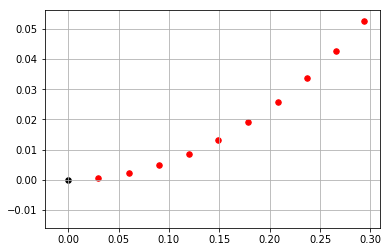

 -- x_train -- 
[[ 2.99937487e-02  5.30344738e-04 -1.53543633e+00]
 [ 5.99499993e-02  2.12071591e-03 -1.50007633e+00]
 [ 8.98313005e-02  4.76912525e-03 -1.46471633e+00]
 [ 1.19600295e-01  8.47226170e-03 -1.42935633e+00]
 [ 1.49219764e-01  1.32254956e-02 -1.39399633e+00]
 [ 1.78652680e-01  1.90228845e-02 -1.35863633e+00]
 [ 2.07862244e-01  2.58571805e-02 -1.32327633e+00]
 [ 2.36811939e-01  3.37198393e-02 -1.28791633e+00]
 [ 2.65465571e-01  4.26010310e-02 -1.25255633e+00]
 [ 2.93787319e-01  5.24896525e-02 -1.21719633e+00]]


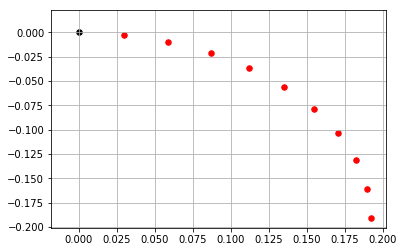

 -- x_train -- 
[[ 2.98782189e-02 -2.33764373e-03 -1.72695633e+00]
 [ 5.90293085e-02 -9.29368502e-03 -1.88311633e+00]
 [ 8.67438356e-02 -2.06988387e-02 -2.03927633e+00]
 [ 1.12347327e-01 -3.62755439e-02 -2.19543633e+00]
 [ 1.35216686e-01 -5.56447194e-02 -2.35159633e+00]
 [ 1.54795354e-01 -7.83349886e-02 -2.50775633e+00]
 [ 1.70606855e-01 -1.03794151e-01 -2.66391633e+00]
 [ 1.82266395e-01 -1.31402622e-01 -2.82007633e+00]
 [ 1.89490221e-01 -1.60488510e-01 -2.97623633e+00]
 [ 1.92102532e-01 -1.90343968e-01 -3.13239633e+00]]


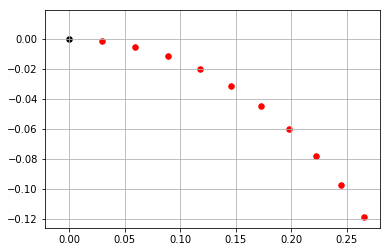

 -- x_train -- 
[[ 2.99646653e-02 -1.26045718e-03 -1.65487633e+00]
 [ 5.97176217e-02 -5.03292322e-03 -1.73895633e+00]
 [ 8.90486562e-02 -1.12907446e-02 -1.82303633e+00]
 [ 1.17750537e-01 -1.99897080e-02 -1.90711633e+00]
 [ 1.45620477e-01 -3.10683528e-02 -1.99119633e+00]
 [ 1.72461567e-01 -4.44484053e-02 -2.07527633e+00]
 [ 1.98084167e-01 -6.00353316e-02 -2.15935633e+00]
 [ 2.22307247e-01 -7.77190057e-02 -2.24343633e+00]
 [ 2.44959663e-01 -9.73744874e-02 -2.32751633e+00]
 [ 2.65881370e-01 -1.18862905e-01 -2.41159633e+00]]


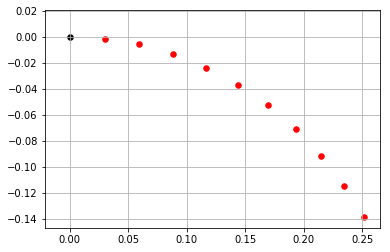

 -- x_train -- 
[[ 2.99491219e-02 -1.51221638e-03 -1.67169633e+00]
 [ 5.95935960e-02 -6.03348299e-03 -1.77259633e+00]
 [ 8.86318736e-02 -1.35178087e-02 -1.87349633e+00]
 [ 1.16768572e-01 -2.38890617e-02 -1.97439633e+00]
 [ 1.43717480e-01 -3.70417437e-02 -2.07529633e+00]
 [ 1.69204469e-01 -5.28420633e-02 -2.17619633e+00]
 [ 1.92970280e-01 -7.11292970e-02 -2.27709633e+00]
 [ 2.14773164e-01 -9.17174237e-02 -2.37799633e+00]
 [ 2.34391337e-01 -1.14397017e-01 -2.47889633e+00]
 [ 2.51625241e-01 -1.38937377e-01 -2.57979633e+00]]


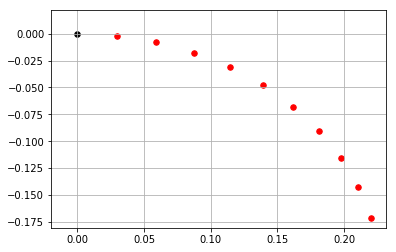

 -- x_train -- 
[[ 2.99125865e-02 -1.98130839e-03 -1.70307633e+00]
 [ 5.93025254e-02 -7.89061516e-03 -1.83535633e+00]
 [ 8.76563011e-02 -1.76246700e-02 -1.96763633e+00]
 [ 1.14478502e-01 -3.10133945e-02 -2.09991633e+00]
 [ 1.39300478e-01 -4.78228544e-02 -2.23219633e+00]
 [ 1.61688526e-01 -6.77593463e-02 -2.36447633e+00]
 [ 1.81251472e-01 -9.04745300e-02 -2.49675633e+00]
 [ 1.97647502e-01 -1.15571514e-01 -2.62903633e+00]
 [ 2.10590136e-01 -1.42611792e-01 -2.76131633e+00]
 [ 2.19853234e-01 -1.71122903e-01 -2.89359633e+00]]


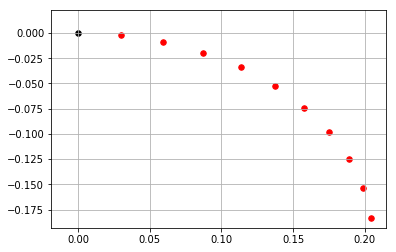

 -- x_train -- 
[[ 2.98932711e-02 -2.18879820e-03 -1.71697633e+00]
 [ 5.91489018e-02 -8.70850451e-03 -1.86315633e+00]
 [ 8.71428528e-02 -1.94200499e-02 -2.00933633e+00]
 [ 1.13277997e-01 -3.40949509e-02 -2.15551633e+00]
 [ 1.36996858e-01 -5.24201838e-02 -2.30169633e+00]
 [ 1.57793497e-01 -7.40048607e-02 -2.44787633e+00]
 [ 1.75224312e-01 -9.83885683e-02 -2.59405633e+00]
 [ 1.88917492e-01 -1.25051188e-01 -2.74023633e+00]
 [ 1.98580956e-01 -1.53423992e-01 -2.88641633e+00]
 [ 2.04008574e-01 -1.82901771e-01 -3.03259633e+00]]


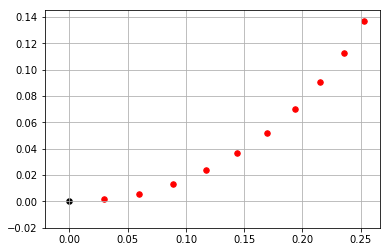

 -- x_train -- 
[[ 0.02995055  0.00149082 -1.47132633]
 [ 0.05960501  0.00594854 -1.37185633]
 [ 0.08867021  0.0133291  -1.27238633]
 [ 0.1168588   0.02355952 -1.17291633]
 [ 0.14389211  0.03653867 -1.07344633]
 [ 0.16950288  0.05213823 -0.97397633]
 [ 0.19343793  0.07020399 -0.87450633]
 [ 0.21546063  0.09055735 -0.77503633]
 [ 0.23535325  0.11299708 -0.67556633]
 [ 0.25291914  0.13730135 -0.57609633]]


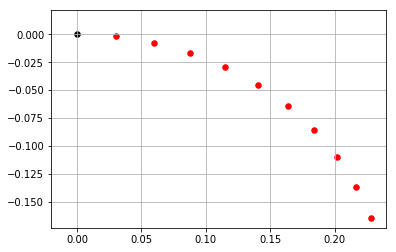

 -- x_train -- 
[[ 2.99219360e-02 -1.87255986e-03 -1.69579633e+00]
 [ 5.93769502e-02 -7.46101879e-03 -1.82079633e+00]
 [ 8.79054070e-02 -1.66781707e-02 -1.94579633e+00]
 [ 1.15062129e-01 -2.93801851e-02 -2.07079633e+00]
 [ 1.40423346e-01 -4.53688513e-02 -2.19579633e+00]
 [ 1.63593302e-01 -6.43946715e-02 -2.32079633e+00]
 [ 1.84210441e-01 -8.61607540e-02 -2.44579633e+00]
 [ 2.01953036e-01 -1.10327447e-01 -2.57079633e+00]
 [ 2.16544223e-01 -1.36517636e-01 -2.69579633e+00]
 [ 2.27756309e-01 -1.64322633e-01 -2.82079633e+00]]


In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [7]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

'''
def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error
'''

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    # limit v
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,i], DATA_M_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    # limit w
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,i] , DATA_RAD_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_distance) + '\t'
    '''
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_distance) + '\t'
    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [ ]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # clip
            v_limit = 0.5 / DATA_HZ
            w_limit = (xp.pi*0.5) / DATA_HZ
            v = F.expand_dims(F.transpose(F.clip(y[:,:,0],-v_limit,v_limit)),axis=0)
            w = F.expand_dims(F.transpose(F.clip(y[:,:,1],-w_limit,w_limit)),axis=0)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
            y_pad = F.concat((v,pad,w),axis=2)
            #y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

In [ ]:
EPOCH = 20
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 0.30785167


In [ ]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

In [ ]:
rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# clip
v_limit = DATA_M_PER_STEP
w_limit = DATA_RAD_PER_STEP
v = F.expand_dims(F.transpose(F.clip(y[:,:,0],-v_limit,v_limit)),axis=0)
w = F.expand_dims(F.transpose(F.clip(y[:,:,1],-w_limit,w_limit)),axis=0)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
y_pad = F.concat((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

In [ ]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    rand_trans_x = xp.random.rand() * DATA_M_PER_STEP
    d_trans = data.translate_path(d,rand_trans_x,0.0)
    rand_rotate = xp.random.rand()*(xp.pi)-xp.pi/2
    d_rotate = data.rotate_path(d_trans,rand_rotate)
    
    x_test = d_rotate
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # clip
    v_limit = 0.5 / DATA_HZ
    w_limit = (xp.pi*0.5) / DATA_HZ
    v = F.expand_dims(F.transpose(F.clip(y[:,:,0],-v_limit,v_limit)),axis=0)
    w = F.expand_dims(F.transpose(F.clip(y[:,:,1],-w_limit,w_limit)),axis=0)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
    y_pad = F.concat((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true)
    fig.savefig(dirname + '/test' + str(i) + '.png')